# ECI 249 HW \#2

Kenneth Larrieu

Take $Q = $ flood flow, $q = $ levee design max flood flow.

We know the following:

Stage-discharge relation: $S(Q)$

Flood damage as a function of flood flow and levee design max flow: $D(Q, q)$

Annualized cost of levee construction as a function of levee design max flow: $C(q)$

The CDF of max annual flood flow frequency (Gumbel, EVI):

$$F(Q) = e^{-e^{-a(Q-b)}}$$

Thus, the pdf is:

$$f(Q) = a e^{-a(Q-b)} e^{-e^{-a(Q-b)}}$$

where $a = \frac{\pi}{\sqrt{6} \sigma}$, $b = \mu - \frac{0.5772}{a}$

## a. Estimate optimal levee height if built now and assuming the flood frequency parameters are known with certainty to be their average values.

In this case, we take $\mu = 60,000$ cfs, $\sigma = 21,000$ cfs.

The total expected value cost to minimize is then:

$$\text{EVC}(q) = \int_q^{\infty} D(Q, q) f(Q) dQ + C(q)$$

In [1]:
import numpy as np
import mpmath as mp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
%matplotlib inline

def damage(Q, q):
    '''Returns flood damage in USD.
    Q = flood flow (cfs)
    q = designed flood flow (cfs)
    '''
    if Q <= q:
        return 0    
    else:
        d0 = 1000000 # damage per foot overbank, given Q > q
        sf = 0.005*(Q-60000)**0.7 # flood stage above bank (ft)
        d = d0*sf
        return d
        
def cost(q):
    '''Returns cost (USD) to build levee protecting up to design flow q (cfs)'''
    if q <= 60000:
        return 0
    else:
        c0 = 10 # cost per cubic yard
        l = 2000 # length
        sl = 0.005*(q-60000)**0.7 # levee stage above bank (ft)
        sl = (sl+2.0)/3 # add freeboard and convert to yards
        xs = (16.0/3)*sl + 3*((sl)**2) # cross-section area
        r = 0.05 # annualize cost
        c = c0*l*xs*r
        return c
    
def gumbel_pdf(Q, mu=60000, sigma=21000):
    '''The Gumbel pdf for flood of size Q. If no assigned mu and sigma, defaults to average.'''
    a = np.pi/(np.sqrt(6)*sigma)
    b = mu - 0.5772/a
    f = a * (np.e**(-np.e**(-a*(Q-b)))) * np.e**(-a*(Q-b))
    return f

# Calculate expected value of cost for given design flow
def evc(q, integrator='scipy'):
    '''Returns expected value cost for levee height q'''
    integrand = lambda Q: damage(Q, q)*gumbel_pdf(Q)
    if integrator == 'mp':
        expected_damage = mp.quad(integrand, [q, np.inf])
    else:
        expected_damage = integrate.quad(integrand, q, np.inf)[0]
    return expected_damage + cost(q)

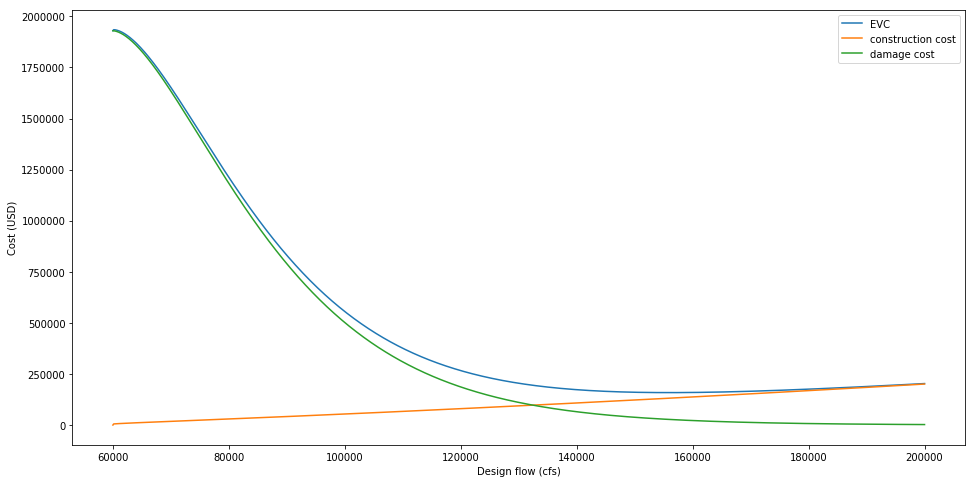

In [2]:
# plot the EVC
fig, ax = plt.subplots(figsize=(16, 8))

qs = np.linspace(60000, 200000, 1001)
total_costs = [evc(q, integrator='mp') for q in qs]
costs = [cost(q) for q in qs]
d_costs = [ev-c for ev, c in list(zip(total_costs, costs))]
ax.plot(qs, total_costs, label = 'EVC')
ax.plot(qs, costs, label='construction cost')
ax.plot(qs, d_costs, label='damage cost')
ax.set_xlabel('Design flow (cfs)')
ax.set_ylabel('Cost (USD)')
ax.legend()
plt.show()

From the plot, we see that the optimal design flow is somewhere between $140,000$ and $180,000$ cfs. The bisection method is used to find this value, and the corresponding optimal levee height:

In [3]:
# use bisection method to find optimal q
def deriv_evc(q, step_size=0.0001):
    '''approximation of EVC derivative'''
    delta_y = evc(q + 0.5*step_size, integrator='mp') - evc(q - 0.5*step_size, integrator='mp')
    return delta_y*1.0/step_size

def bisection():
    best_cost = np.inf
    best_q = None
    i = 0
    tolerance = 0.01
    q_min = 140000
    q_max = 180000
    q = (q_min + q_max)/2.0

    while True:
        if deriv_evc(q_min)*deriv_evc(q) < 0:
            q_max = q
        elif deriv_evc(q)*deriv_evc(q_max) < 0:
            q_min = q
        elif deriv_evc(q) == 0:
            best_q = q
            best_cost = evc(best_q, integrator='mp')
            print('Got q!')
            break

        q_old = q
        q = (q_min + q_max)/2.0

        if abs(q - q_old) < tolerance:
            best_q = q
            best_cost = evc(best_q, integrator='mp')
            print('Got q within tolerance after %i iterations' % i)
            break

        i+=1
        if i > 1000:
            print('Hit max iters')
            break
    
    print('optimal q = %.2f cfs' % best_q)
    # convert design flow to a levee design height
    h = 0.005*(best_q-60000)**0.7
    print('optimal height = %.2f ft' % h)
    return best_q, best_cost, h
            
best_q, best_cost, h = bisection()

Got q within tolerance after 20 iterations
optimal q = 155988.04 cfs
optimal height = 15.36 ft


## b. Estimate the optimal height of the levee for this case, if it is built now but assuming the flood frequency parameters are known only in terms of their probability distributions.

Since the parameters $\mu_Q$ and $\sigma_Q$ are independently distributed, the joint distribution becomes:

$$f(Q, \mu_Q, \sigma_Q) = f_{Q, \mu_Q, \sigma_Q}(Q, \mu_Q, \sigma_Q) = f_{Q | \mu_Q, \sigma_Q}(Q | \mu_Q, \sigma_Q) \cdot f_{\mu_Q}(\mu_Q) \cdot f_{\sigma_Q}(\sigma_Q)$$

Where the distributions of $\mu_Q$ and $\sigma_Q$ are the following:

$$f_{\mu_Q}(\mu_Q) = \frac{1}{\sqrt{2 \pi} \sigma_{\mu}} e^{- \frac{(\mu_Q - \mu_{\mu})^2}{2 \sigma_{\mu}^2}}$$

$$f_{\sigma_Q}(\sigma_Q) = \frac{1}{\sqrt{2 \pi} \sigma_{\sigma}} e^{- \frac{(\mu_Q - \mu_{\sigma})^2}{2 \sigma_{\sigma}^2}}$$

The expression for expected value of cost becomes:

$$\text{EVC}(q) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_q^{\infty} D(Q, q) f(Q, \mu_Q, \sigma_Q) dQ d\mu_Q d\sigma_Q + C(q)$$

In [4]:
def mean_pdf(mu):
    mu_mu = 60000
    sigma_mu = 21000/(np.sqrt(40)) # from central limit theorem, 40 years of samples
    
    return 1.0/(np.sqrt(2*np.pi)*sigma_mu) * np.e**(-((mu-mu_mu)**2)/(2*sigma_mu**2))
    
def std_pdf(sigma):
    mu_sigma = 21000
    sigma_sigma = 7000
    
    return 1.0/(np.sqrt(2*np.pi)*sigma_sigma) * np.e**(-((sigma-mu_sigma)**2)/(2*sigma_sigma**2))

# redefine evc for triple integral
def evc(q, num):
    integrand = lambda Q, mu, sigma: damage(Q, q)*gumbel_pdf(Q, mu=mu, sigma=sigma)*mean_pdf(mu)*std_pdf(sigma)
    integral = 0
    # just integrate within 2 sigma of each normal dist
    sig_min, sig_max = (7000, 28000)
    mu_min, mu_max = (53000, 67000)
    # for gumbel integrate from q cfs (bc damage=0 below this) to 200k
    Q_min, Q_max = (q, 200000)
    dq = (Q_max-Q_min)*1.0/num
    dm = (mu_max-mu_min)*1.0/num
    ds = (sig_max-sig_min)*1.0/num
    for sigma in np.linspace(sig_min, sig_max, num):
        for mu in np.linspace(mu_min, mu_max, num):
            for Q in np.linspace(Q_min, Q_max, num):
                integral += integrand(Q, mu, sigma)
    integral = integral*dq*dm*ds
    integral += cost(q)
    return integral

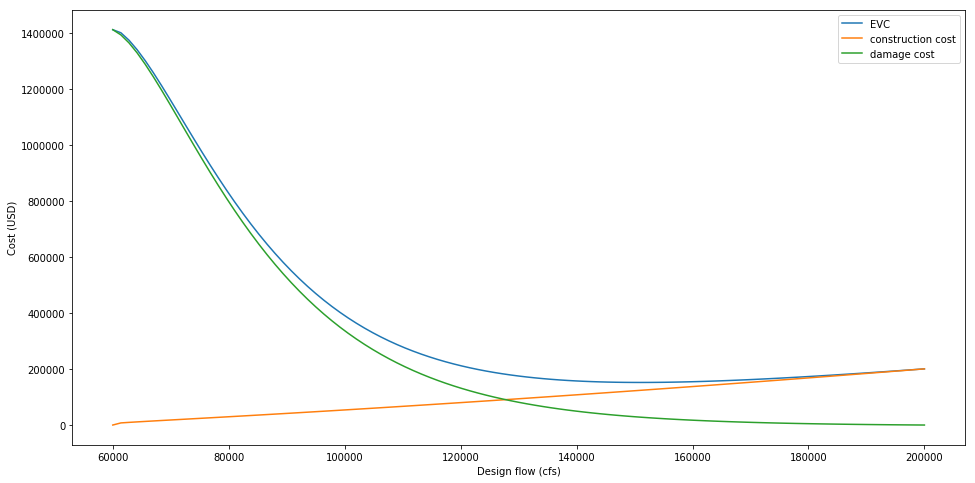

In [5]:
# plot the EVC estimates
fig, ax = plt.subplots(figsize=(16, 8))

qs = np.linspace(60000, 200000, 101)
total_costs = [evc(q, 101) for q in qs]
costs = [cost(q) for q in qs]
d_costs = [ev-c for ev, c in list(zip(total_costs, costs))]
ax.plot(qs, total_costs, label = 'EVC')
ax.plot(qs, costs, label='construction cost')
ax.plot(qs, d_costs, label='damage cost')
ax.set_xlabel('Design flow (cfs)')
ax.set_ylabel('Cost (USD)')
ax.legend()
plt.show()

In [7]:
def deriv_evc(q, step_size=0.5):
    '''approximation of EVC derivative'''
    delta_y = evc(q + 0.5*step_size, 201) - evc(q - 0.5*step_size, 201)
    return delta_y*1.0/step_size

def bisection():
    best_cost = np.inf
    best_q = None
    i = 0
    tolerance = 1
    q_min = 140000
    q_max = 180000
    q = (q_min + q_max)/2.0

    while True:
        d_center = deriv_evc(q)
        if deriv_evc(q_min)*d_center < 0:
            q_max = q
        elif d_center*deriv_evc(q_max) < 0:
            q_min = q
        elif d_center == 0:
            best_q = q
            best_cost = evc(best_q, 201)
            print('Got q!')
            break

        q_old = q
        q = (q_min + q_max)/2.0

        if abs(q - q_old) < tolerance:
            best_q = q
            best_cost = evc(best_q, 201)
            print('Got q within tolerance after %i iterations' % i)
            break

        i+=1
        if i > 1000:
            print('Hit max iters')
            break
            
    print('optimal q = %.2f cfs' % best_q)
    # convert design flow to a levee design height
    h = 0.005*(best_q-60000)**0.7
    print('optimal height = %.2f ft' % h)
    return best_q, best_cost, h

best_q, best_cost, h = bisection()

Got q within tolerance after 14 iterations
optimal q = 151331.18 cfs
optimal height = 14.84 ft


## c. Is it worthwhile to wait for additional data before building the levee? What are some of the weaknesses of this methodology? In what ways might it be extended?

